<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/S_10_LRFinder_Misclassified_Cifar10/EVA4_S12_tinyImagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sources:
## [Paper](http://cs231n.stanford.edu/reports/2017/pdfs/930.pdf)
## [Data Augmentation Techniques](https://pytorch.org/docs/stable/torchvision/transforms.html)

# Mount Google drive

In [25]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


import sys,os
from pathlib import Path


homepath = Path('/content/drive/My Drive/pytorch_Framework_suman/')
sys.path.append(str(homepath))

sys.path.append(os.path.join(homepath,'lib'))
print(sys.path)

!ls


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/pytorch_Framework_suman', '/content/drive/My Drive/pytorch_Framework_suman/lib', '/content/drive/My Drive/pytorch_Framework_suman', '/content/drive/My Drive/pytorch_Framework_suman/lib']
test  test_set	train  train_set  val  wnids.txt  words.txt


# Copy the tiny-Imagenet data set to colab 
[link](https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf)

In [26]:
zip_path = os.path.join(homepath,'data/tinyImagenet/tiny-imagenet-200.zip')
print('tiny-dataset zip file path is at : {}'.format(zip_path))

tiny-dataset zip file path is at : /content/drive/My Drive/pytorch_Framework_suman/data/tinyImagenet/tiny-imagenet-200.zip


In [0]:
if not os.path.exists(os.path.basename(zip_path).split('.zip')[0]):
    !cp "{zip_path}" .
    !unzip -q "{os.path.basename(zip_path)}"
    !rm "{os.path.basename(zip_path)}"

In [0]:
if os.getcwd() != '/content/tiny-imagenet-200':
    os.chdir(os.path.basename(zip_path).split('.zip')[0])
    !ls 

# Initialize device

In [29]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


# Split the dataset (train and validation) into 70+30

In [30]:
os.chdir('/content/')
!ls


drive  sample_data  tiny-imagenet-200


In [0]:
import io,glob,os,time,random
from shutil import move
from os.path import join
from os import listdir,rmdir

import scipy.ndimage as nd
import numpy as np


target_folder = './tiny-imagenet-200/val/'
dest_folder = './tiny-imagenet-200/train/'

val_dict={}

with open('./tiny-imagenet-200/val/val_annotations.txt','r') as f:
    for line in f.readlines():
        splitline = line.split('\t')
        val_dict[splitline[0]] = splitline[1]
    paths = glob.glob('./tiny-imagenet-200/val/images/*')
  
    for path in paths:
        file = path.split('/')[-1].split('\\')[-1]
        folder = val_dict[file]
        dest = dest_folder + str(folder) + '/images/' + str(file)
        move(path,dest)
		

In [0]:
target_folder = './tiny-imagenet-200/train/'
train_folder = './tiny-imagenet-200/train_set/'
test_folder = './tiny-imagenet-200/test_set/'
 
if not os.path.exists(train_folder) and not os.path.exists(test_folder):
    os.mkdir(train_folder)
    os.mkdir(test_folder)
 
    paths = glob.glob('./tiny-imagenet-200/train/*')
    
    for path in paths:
        folder = path.split('/')[-1].split('\\')[-1]
        source = target_folder + str(folder + '/images/')
        train_dest = train_folder + str(folder + '/')
        test_dest = test_folder + str(folder + '/')

        os.mkdir(train_dest)
        os.mkdir(test_dest)
        images = glob.glob(source + str('*'))
        #print(len(images))
        # making random
        random.shuffle(images)
      
        test_imgs = images[:165].copy()
        train_imgs = images[165:].copy()
      
        # moving 30% for validation
        for image in test_imgs:
          file = image.split('/')[-1].split('\\')[-1]
          dest = test_dest + str(file)
          move(image, dest)
      
        # moving 70% for training
        for image in train_imgs:
          file = image.split('/')[-1].split('\\')[-1]
          dest = train_dest + str(file)
          move(image, dest)

In [33]:
print('test_set dir len is : {}'.format(len(os.listdir('./tiny-imagenet-200/test_set/n01629819/'))))
print('train_set dir len is : {}'.format(len(os.listdir('./tiny-imagenet-200/train_set/n01629819/'))))

test_set dir len is : 165
train_set dir len is : 385


# Load train and validation dataset

In [0]:
os.chdir('/content/tiny-imagenet-200')

- **torchvision.transforms.RandomApply(transforms, p=0.5)** : 
      transforms (list or tuple) – list of transformations
      p (python:float) – probability
- **RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')** : 
      Crop the given PIL Image at a random location.
      padding_mode –

      **Type of padding**. Should be: constant, edge, reflect or symmetric. Default is constant.

         1. constant: pads with a constant value, this value is specified with fill

         2. edge: pads with the last value on the edge of the image

         3. reflect: pads with reflection of image (without repeating the last value on the edge)

         4. padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode will result in [3, 2, 1, 2, 3, 4, 3, 2]

         5. symmetric: pads with reflection of image (repeating the last value on the edge)

         6. padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode will result in [2, 1, 1, 2, 3, 4, 4, 3]


- **CenterCrop(size)** : Crops the given PIL Image at the center.
    size (sequence or python:int) – Desired output size of the crop. 

- **RandomHorizontalFlip(p=0.5)** : Horizontally flip the given PIL Image randomly with a given probability. 
    - p (python:float) – probability of the image being flipped. Default value is 0.5
- 

In [0]:
import torchvision
import torch.utils.data as data
from torchvision.datasets import ImageFolder
import albumentations
import torchvision.transforms as tt
#from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
#                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded 
#                           )

# Add albumentation transformations

In [0]:
# tt.RandomApply(transforms, p=0.5)
from lib.cutout import Cutout
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(56, padding=4, padding_mode='reflect'),
                  tt.RandomHorizontalFlip(p=0.5),
                  tt.RandomRotation(degrees=([-90,90]), resample=False, expand=False, center=None, fill=0),
                  tt.ColorJitter(brightness=([0.7,1.3]), contrast=([0.7,1.3]), saturation=([0.7,1.3]), hue=0),
                  #tt.RandomAffine(degrees=([-90,90]), translate=([0,1]), scale=([56,56]), shear=None, resample=False, fillcolor=0),
                  #tt.functional.adjust_gamma(img, gamma, gain=1),
                  tt.ToTensor(), 
                  Cutout(n_holes=2, length=16),
                  tt.Normalize(*stats)
                  
                  
])

valid_tfms = tt.Compose([tt.CenterCrop(56),
                            tt.ToTensor(),
                            tt.Normalize(*stats)
])


In [0]:
train_ds = ImageFolder('train_set', transform=train_tfms)

test_ds = ImageFolder('test_set', transform=valid_tfms)

In [38]:
print('####Validation Dataset is : \n\t\n{}'.format(train_ds))
print('####Validation Dataset is : \n\t\n{}'.format(test_ds))

####Validation Dataset is : 
	
Dataset ImageFolder
    Number of datapoints: 77000
    Root location: train_set
    StandardTransform
Transform: Compose(
               RandomCrop(size=(56, 56), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-90, 90], resample=False, expand=False)
               ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=None)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
####Validation Dataset is : 
	
Dataset ImageFolder
    Number of datapoints: 33000
    Root location: test_set
    StandardTransform
Transform: Compose(
               CenterCrop(size=(56, 56))
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


# Print few images from the train dataset

In [0]:
from matplotlib import pyplot as plt
def show_imgs(img,label):
    print('Image label is : {}'.format(train_ds.classes[label]))
    plt.imshow(img.permute(1, 2, 0))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image label is : n01443537


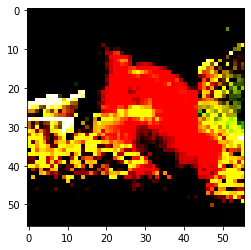

In [40]:
show_imgs(*test_ds[0])

# Print few images from the train dataloader and test data loader

In [0]:
from torch.utils.data import DataLoader
batch_size = 512

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, 
                      num_workers=8, pin_memory=True)

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
def show_batch(dl,numOfImagesToDisplay=10,imgsPerRow=5):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(26, 26))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:numOfImagesToDisplay], imgsPerRow).permute(1, 2, 0))
        break


## Print few images from Train DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


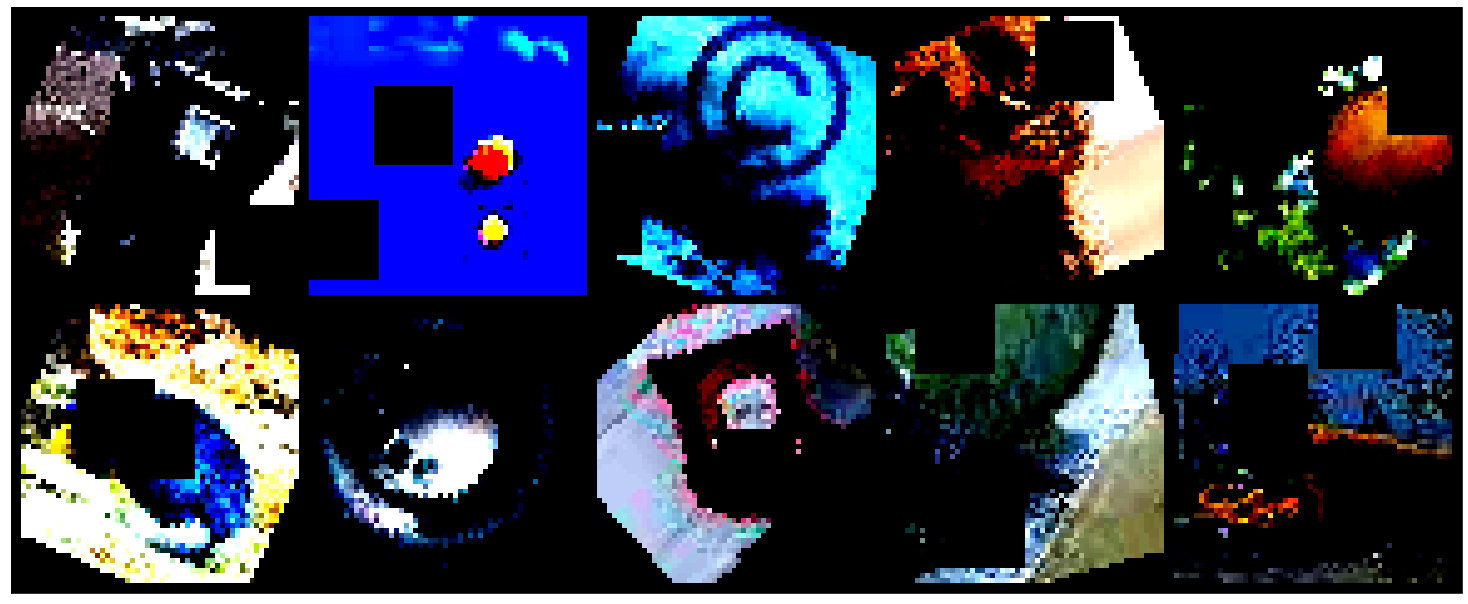

In [44]:
show_batch(train_dl)

## print few Images from Test Data Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


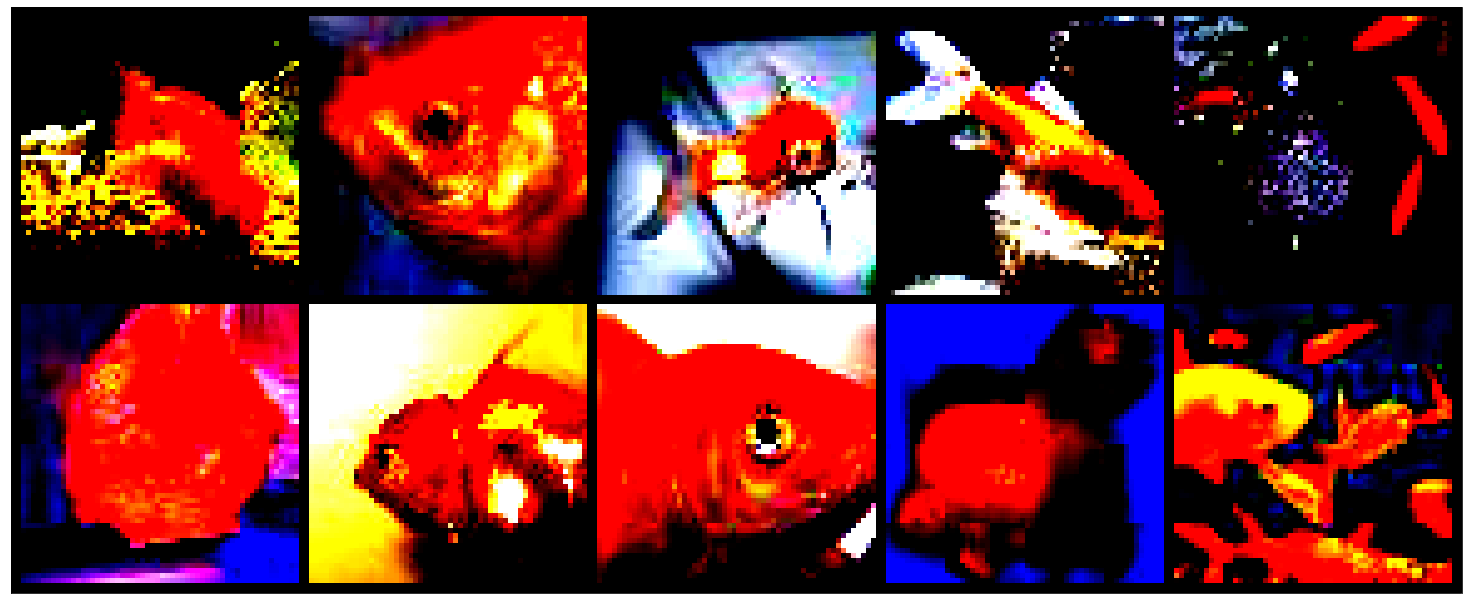

In [45]:
show_batch(test_dl)

# Test the model what we have written

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [46]:
import torchvision.models as models

model = models.resnet18()

#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model = model.to(device)

summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [47]:
for images, labels in train_dl:
    images, labels = images.cuda(), labels.cuda()
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([512, 3, 56, 56])
out.shape: torch.Size([512, 200])


# Implementation of One cycle policy

In [0]:
!pip install torch-lr-finder -v --global-option="amp"


Learning rate search finished. See the graph with {finder_name}.plot()


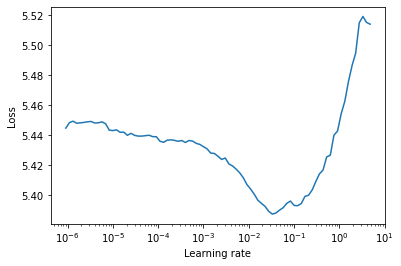

In [49]:
# LR range test
from torch_lr_finder import LRFinder
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, start_lr=1e-7,end_lr=10, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

In [50]:
print('Min loss value is : {} \nMin LR value is   : {}'.format(min(lr_finder.history['loss']),format(min(lr_finder.history['lr']),'.10f')))

print('Min loss observed at index : {}'.format(lr_finder.history['loss'].index(min(lr_finder.history['loss']))))
print('so corresponding LR value at that index is--> LRmax : {}'.format(lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]))
lrmax = lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]
lrmax = float('{:4f}'.format(lrmax))
print(lrmax)

Min loss value is : 5.387284434885325 
Min LR value is   : 0.0000001445
Min loss observed at index : 67
so corresponding LR value at that index is--> LRmax : 0.03311311214825908
0.033113


[Description for OCP](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR)

In [0]:
from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(optimizer, max_lr = lrmax, total_steps=50, epochs=
                       None, steps_per_epoch=None, pct_start=0.5, anneal_strategy='linear', 
                       cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10,final_div_factor=10)

In [52]:
trainaccuracies = []
trainlosses = []
vallosses = []
valaccuracies = []
misclassifieditems = []
lr_values = []

from lib import trainTestMethods
for epoch in range(1,20):
    print("\nEPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.trainWithAccPlt(network=model, trainloader=train_dl, device='cuda', optimizer=optimizer, criterion=criterion, trainaccuracies=trainaccuracies, trainlosses=trainlosses, epoch=epoch)
    scheduler.step()
    testloss = trainTestMethods.testWithAccPlt(network=model, testloader=test_dl, device='cuda', criterion=criterion, valaccuracies=valaccuracies, vallosses=vallosses, epoch=epoch)


EPOCH: 1 LR: 0.0033112999999999997

Epoch: 1
 [================================================================>]  Step: 541ms | Tot: 3m21s | Train >> Loss: 5.282 | Acc: 0.932% (718/77000) 151/151 
 [================================================================>]  Step: 54ms | Tot: 15s598ms | Test >> Loss: 5.144 | Acc: 1.718% (567/33000) 65/65 
0.010132931463646166

EPOCH: 2 LR: 0.004553037499999999

Epoch: 2
 [================================================================>]  Step: 525ms | Tot: 3m20s | Train >> Loss: 5.043 | Acc: 2.405% (1852/77000) 151/151 
 [================================================================>]  Step: 57ms | Tot: 15s575ms | Test >> Loss: 4.874 | Acc: 3.867% (1276/33000) 65/65 
0.00959969027114637

EPOCH: 3 LR: 0.005794774999999999

Epoch: 3
 [================================================================>]  Step: 543ms | Tot: 3m20s | Train >> Loss: 4.798 | Acc: 4.555% (3507/77000) 151/151 
 [=======================================================

In [53]:
for epoch in range(20,30):
    print("\nEPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.trainWithAccPlt(network=model, trainloader=train_dl, device='cuda', optimizer=optimizer, criterion=criterion, trainaccuracies=trainaccuracies, trainlosses=trainlosses, epoch=epoch)
    scheduler.step()
    testloss = trainTestMethods.testWithAccPlt(network=model, testloader=test_dl, device='cuda', criterion=criterion, valaccuracies=valaccuracies, vallosses=vallosses, epoch=epoch)


EPOCH: 20 LR: 0.026904312499999996

Epoch: 20
 [================================================================>]  Step: 525ms | Tot: 3m20s | Train >> Loss: 3.596 | Acc: 20.406% (15713/77000) 151/151 
 [================================================================>]  Step: 54ms | Tot: 15s91ms | Test >> Loss: 3.627 | Acc: 20.912% (6901/33000) 65/65 
0.007143525159720218

EPOCH: 21 LR: 0.02814605

Epoch: 21
 [================================================================>]  Step: 540ms | Tot: 3m21s | Train >> Loss: 3.563 | Acc: 20.806% (16021/77000) 151/151 
 [================================================================>]  Step: 55ms | Tot: 15s88ms | Test >> Loss: 3.685 | Acc: 20.139% (6646/33000) 65/65 
0.007258072564096162

EPOCH: 22 LR: 0.0293877875

Epoch: 22
 [================================================================>]  Step: 526ms | Tot: 3m20s | Train >> Loss: 3.525 | Acc: 21.435% (16505/77000) 151/151 
 [===========================================================

In [54]:
for epoch in range(30,50):
    print("\nEPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.trainWithAccPlt(network=model, trainloader=train_dl, device='cuda', optimizer=optimizer, criterion=criterion, trainaccuracies=trainaccuracies, trainlosses=trainlosses, epoch=epoch)
    scheduler.step()
    testloss = trainTestMethods.testWithAccPlt(network=model, testloader=test_dl, device='cuda', criterion=criterion, valaccuracies=valaccuracies, vallosses=vallosses, epoch=epoch)


EPOCH: 30 LR: 0.026556625999999996

Epoch: 30
 [================================================================>]  Step: 527ms | Tot: 3m21s | Train >> Loss: 3.221 | Acc: 26.170% (20151/77000) 151/151 
 [================================================================>]  Step: 56ms | Tot: 14s769ms | Test >> Loss: 3.447 | Acc: 24.345% (8034/33000) 65/65 
0.00678934426018686

EPOCH: 31 LR: 0.025245351199999995

Epoch: 31
 [================================================================>]  Step: 546ms | Tot: 3m20s | Train >> Loss: 3.190 | Acc: 26.799% (20635/77000) 151/151 
 [================================================================>]  Step: 56ms | Tot: 15s179ms | Test >> Loss: 3.430 | Acc: 24.867% (8206/33000) 65/65 
0.006756331371538567

EPOCH: 32 LR: 0.023934076399999997

Epoch: 32
 [================================================================>]  Step: 528ms | Tot: 3m21s | Train >> Loss: 3.150 | Acc: 27.292% (21015/77000) 151/151 
 [========================================

# Plot Metrics - Accuracy and Loss

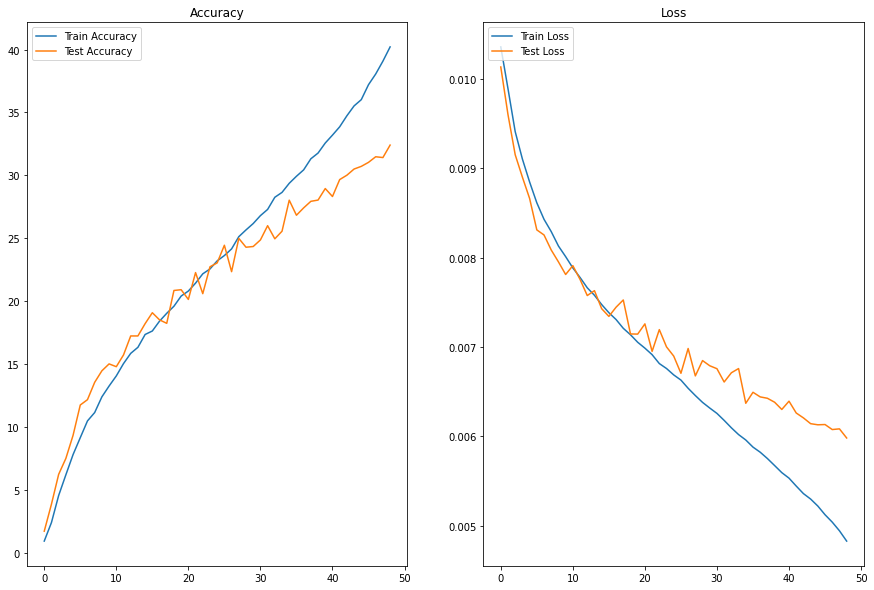

Max. Train Accuracy outoff 49-epochs is : 40.20909090909091 at 49-Epoach
Max. Test Accuracy  outoff 49-epochs is : 32.406060606060606 at 49-Epoach


Min. Train Loss outoff 49-epochs is : 0.004827 at 49-Epoach
Min. Test Loss  outoff 49-epochs is : 0.005981 at 49-Epoach


In [55]:
trainTestMethods.plotmetrics(90,trainaccuracies=trainaccuracies, testaccuracies=valaccuracies, trainlosses=trainlosses, testlosses=vallosses
, savefilename="metrics")

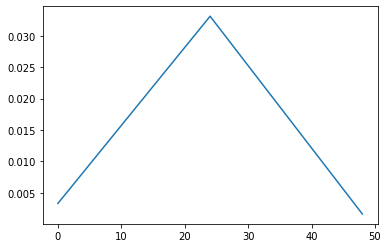

In [56]:
plt.plot(lr_values)